All the necessary imports needed for this project.

In [38]:
# Imports

import warnings  
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import datetime as dt

from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric

Creating two dataframes to store the data from the datasets ("df" and "vaccineDf").

In [39]:
df = pd.read_csv("https://raw.githubusercontent.com/KieranOConnell/covid-19/main/country_vaccinations.csv")
vaccineDf = pd.read_csv("https://raw.githubusercontent.com/KieranOConnell/covid-19/main/country_vaccinations_by_manufacturer.csv")

if not df.empty and not vaccineDf.empty:
    print("File load: Success")
else:
    print("File load: Failed")

File load: Success


https://www.kaggle.com/gpreda/covid-world-vaccination-progress

The data contains the following information:

*   **Country** - this is the country for which the vaccination information is provided;
*   **Country ISO Code** - ISO code for the country;
*   **Date** - date for the data entry; for some of the dates we have only the daily vaccinations, for others, only the (cumulative) total;
*   **Total number of vaccinations** - this is the absolute number of total immunizations in the country;
*   **Total number of people vaccinated** - a person, depending on the immunization scheme, will receive one or more (typically 2) vaccines; at a certain moment, the number of vaccination might be larger than the number of people;
*   **Total number of people fully vaccinated** - this is the number of people that received the entire set of immunization according to the immunization scheme (typically 2); at a certain moment in time, there might be a certain number of people that received one vaccine and another number (smaller) of people that received all vaccines in the scheme;
*   **Daily vaccinations (raw)** - for a certain data entry, the number of vaccination for that date/country;
*   **Daily vaccinations** - for a certain data entry, the number of vaccination for that date/country;
*   **Total vaccinations per hundred** - ratio (in percent) between vaccination number and total population up to the date in the country;
*   **Total number of people vaccinated per hundred** - ratio (in percent) between population immunized and total population up to the date in the country;
*   **Total number of people fully vaccinated per hundred** - ratio (in percent) between population fully immunized and total population up to the date in the country;
*   **Number of vaccinations per day** - number of daily vaccination for that day and country;
*   **Daily vaccinations per million** - ratio (in ppm) between vaccination number and total population for the current date in the country;
*   **Vaccines used in the country** - total number of vaccines used in the country (up to date);
*   **Source name** - source of the information (national authority, international organization, local organization etc.);
*   **Source website** - website of the source of information;












---



---



**STAGE 1**: Describe the data, plenty plots and stats, with a view to gleaning some information or understanding which will lead you to...



---



---



Getting 3 random entries in the dataset to see what information is returned and to begin to understand which data may be worth analysing further.

In [40]:
df.sample(3)

,country,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,daily_vaccinations_per_million,vaccines,source_name,source_website
7996,Mexico,MEX,2021-02-09,NaN,NaN,NaN,NaN,6246.0,NaN,NaN,NaN,48.0,"CanSino, Oxford/AstraZeneca, Pfizer/BioNTech, ...",Secretary of Health,https://www.gob.mx/cms/uploads/attachment/file...
13567,Zimbabwe,ZWE,2021-03-22,43574.0,43294.0,280.0,845.0,845.0,0.29,0.29,0.0,57.0,Sinopharm/Beijing,Ministry of Health,https://twitter.com/MoHCCZim/status/1385677011...
5989,Ireland,IRL,2021-04-15,NaN,NaN,NaN,NaN,17512.0,NaN,NaN,NaN,3547.0,"Moderna, Oxford/AstraZeneca, Pfizer/BioNTech",Heath Service Executive,https://covid19ireland-geohive.hub.arcgis.com/


Viewing the shape of the dataframe: 13600 entries with 15 columns

In [41]:
df.shape

(13600, 15)

Getting various information about the data such as the types of each column; they consist of types float64 and object

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13600 entries, 0 to 13599
Data columns (total 15 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   country                              13600 non-null  object 
 1   iso_code                             13600 non-null  object 
 2   date                                 13600 non-null  object 
 3   total_vaccinations                   8096 non-null   float64
 4   people_vaccinated                    7387 non-null   float64
 5   people_fully_vaccinated              5377 non-null   float64
 6   daily_vaccinations_raw               6781 non-null   float64
 7   daily_vaccinations                   13388 non-null  float64
 8   total_vaccinations_per_hundred       8096 non-null   float64
 9   people_vaccinated_per_hundred        7387 non-null   float64
 10  people_fully_vaccinated_per_hundred  5377 non-null   float64
 11  daily_vaccinations_per_milli

Descriptive statistics including those that summarize the central tendency, dispersion and shape of a dataset’s distribution, excluding NaN values. For example, this tells us that there are 8096 entries updating the total number of vaccinations

In [43]:
# https://stackoverflow.com/questions/40347689/dataframe-describe-suppress-scientific-notation

df.describe().apply(lambda s: s.apply('{0:.5f}'.format))

,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,daily_vaccinations_per_million
count,8096.00000,7387.00000,5377.00000,6781.00000,13388.00000,8096.00000,7387.00000,5377.00000,13388.00000
mean,4389971.36129,2944091.90524,1406707.75414,128119.16148,73751.99238,14.25169,10.51787,5.20760,2939.10913
std,17588747.04638,10765816.39792,5989352.95611,477958.34620,324119.26104,22.14557,14.74565,9.65638,4819.77980
min,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
25%,55776.50000,48599.00000,22164.00000,2906.00000,937.00000,1.18000,1.08000,0.59000,341.75000
50%,383996.00000,304680.00000,158820.00000,15431.00000,6013.50000,5.67000,4.40000,2.14000,1444.00000
75%,1782536.00000,1288127.00000,637533.00000,61123.00000,27697.00000,17.85250,13.22000,5.56000,3762.00000
max,222322230.00000,137234889.00000,91175995.00000,7185000.00000,5190143.00000,201.75000,106.77000,94.98000,118759.00000


Checking how many null values are in the dataset. Some of these columns have no null values as the information they provide is necessary to be included with each entry - for example the country in which the vaccination occurred.

In [44]:
df.isnull().sum()

country                                   0
iso_code                                  0
date                                      0
total_vaccinations                     5504
people_vaccinated                      6213
people_fully_vaccinated                8223
daily_vaccinations_raw                 6819
daily_vaccinations                      212
total_vaccinations_per_hundred         5504
people_vaccinated_per_hundred          6213
people_fully_vaccinated_per_hundred    8223
daily_vaccinations_per_million          212
vaccines                                  0
source_name                               0
source_website                            0
dtype: int64

A common problem when dealing with real-world data is missing values. These can arise for many reasons and have to be either filled in or removed before we train a machine learning model. First, let’s get a sense of how many missing values are in each column

In [45]:
# https://stackoverflow.com/questions/26266362/how-to-count-the-nan-values-in-a-column-in-pandas-dataframe/55455380

def missing_values_table(df):
  mis_val = df.isnull().sum()
  mis_val_percent = 100 * df.isnull().sum() / len(df)
  mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
  mis_val_table_ren_columns = mis_val_table.rename(
  columns = {0 : 'Missing Values', 1 : '% of Total Values'})
  mis_val_table_ren_columns = mis_val_table_ren_columns[
      mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
  '% of Total Values', ascending=False).round(1)
  print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
      "There are " + str(mis_val_table_ren_columns.shape[0]) +
        " columns that have missing values.")
  return mis_val_table_ren_columns

In [46]:
missing_values_table(df)

Your selected dataframe has 15 columns.
There are 9 columns that have missing values.


,Missing Values,% of Total Values
people_fully_vaccinated,8223,60.5
people_fully_vaccinated_per_hundred,8223,60.5
daily_vaccinations_raw,6819,50.1
people_vaccinated,6213,45.7
people_vaccinated_per_hundred,6213,45.7
total_vaccinations,5504,40.5
total_vaccinations_per_hundred,5504,40.5
daily_vaccinations,212,1.6
daily_vaccinations_per_million,212,1.6


The dataset has 9 columns with missing values. A simple solution to resolve this issue would be to use "ffill", which stands for "forward fill". This will propagate the last valid observation forward. For any remaining missing values (about 30), we can simply drop them from the dataset.

In [47]:
df.fillna(method="ffill", inplace=True)
df.dropna(inplace=True)
df.isnull().sum()

country                                0
iso_code                               0
date                                   0
total_vaccinations                     0
people_vaccinated                      0
people_fully_vaccinated                0
daily_vaccinations_raw                 0
daily_vaccinations                     0
total_vaccinations_per_hundred         0
people_vaccinated_per_hundred          0
people_fully_vaccinated_per_hundred    0
daily_vaccinations_per_million         0
vaccines                               0
source_name                            0
source_website                         0
dtype: int64

In [48]:
df.shape

(13517, 15)

Lets take a look at the 10 countries with the highest total number of vaccinations so far. As seen from the bar chart, the United States is leading with over 200 million vaccinations, with China following close behind.

In [49]:
top10Df = df.groupby(["country"])["total_vaccinations"].max().reset_index()
top10Df.sort_values(by="total_vaccinations", ascending=False, inplace=True)
top10Df = top10Df[0:9]

In [50]:
fig = px.bar(data_frame=top10Df, x="country", y="total_vaccinations", color="country", title="Top 10 Countries - Total Vaccinations", labels={"country":"Country", "total_vaccinations":"Total Vaccinations"})
fig.update_layout(showlegend=False)
fig.show()

Lets compare how the top 5 countries' total vaccination numbers increased over time.

In [51]:
top5Df = df[(df.country== "United States") | (df.country== "China") | (df.country== "India") | (df.country== "United Kingdom") | (df.country== "England")]

fig = px.line(data_frame=top5Df, x="date", y="total_vaccinations", color="country", title="Top 5 Countries - Total Vaccinations", color_discrete_sequence=["red", "blue", "yellow", "black", "green"])
fig.show()

Lets look at the figures for the total vaccinations per hundred and compare them with the results above.

These results reveal a very interesting fact. Although China has almost as many total vaccinations as the United States, they only have a 15% vaccination per hundred rate, whereas the United States has an almost 66% vaccination per hundred rate. This is of course because the population of China is over 4 times that of the United States.

In [52]:
fig = px.line(data_frame=top5Df, x="date", y="total_vaccinations_per_hundred", color="country", title="Top 5 Countries - Total Vaccinations", color_discrete_sequence=["red", "blue", "yellow", "black", "green"])
fig.show()

The data for vaccine manufacturers in this dataset is stored in such a way that it lists all of the manufacturers that were used on a particular day for each country. For this reason, it is difficult to access the individual manufacturers of vaccines. Lets see if we can see how many unique vaccine manufacturers there are and list them out

In [53]:
vaccineManufacturers=[]
manufacturers = [manufacturer.split(', ') for manufacturer in set(df["vaccines"])]

for manufacturer in manufacturers:
  for i in manufacturer:
    vaccineManufacturers.append(i)

vaccineManufacturers=np.unique(vaccineManufacturers)

print("There are " + str(len(vaccineManufacturers)) + " COVID-19 vaccine manufacturers:\n")

for manufacturer in vaccineManufacturers:
  print(manufacturer)

There are 11 COVID-19 vaccine manufacturers:

CanSino
Covaxin
EpiVacCorona
Johnson&Johnson
Moderna
Oxford/AstraZeneca
Pfizer/BioNTech
Sinopharm/Beijing
Sinopharm/Wuhan
Sinovac
Sputnik V


As the United States currently has the total highest number of vaccinations as of now, lets look at which vaccines were used most frequently there and display that information on a pie chart.

As shown, 51% of the population have received the Pfizer/BioNTech vaccine, 46.2% of people have received Moderna, while only 2.13% of people have been given the Johnson&Johnson vaccine.

In [54]:
unitedStatesDf = vaccineDf[vaccineDf["location"] == "United States"].groupby(["vaccine"])["total_vaccinations"].sum().reset_index()

fig = px.pie(data_frame=unitedStatesDf, values="total_vaccinations", names="vaccine", title="United States COVID-19 Vaccines", template="presentation", color_discrete_sequence=["black", "red", "yellow"])
fig.update_traces(rotation=90, pull=0.05, textinfo="label+percent")
fig.update_layout(showlegend=False)
fig.show()

# New Section

Lets use a word cloud to visualise how frequently each vaccine is used throughout the world. This is a useful method to comprehend which vaccine is adminstered most by viewing the size of the words inside the word cloud.

It would appear that the three major leaders for vaccine manufacturers are: Pfizer/BioNTech, Oxford/AstraZeneca, and Moderna.

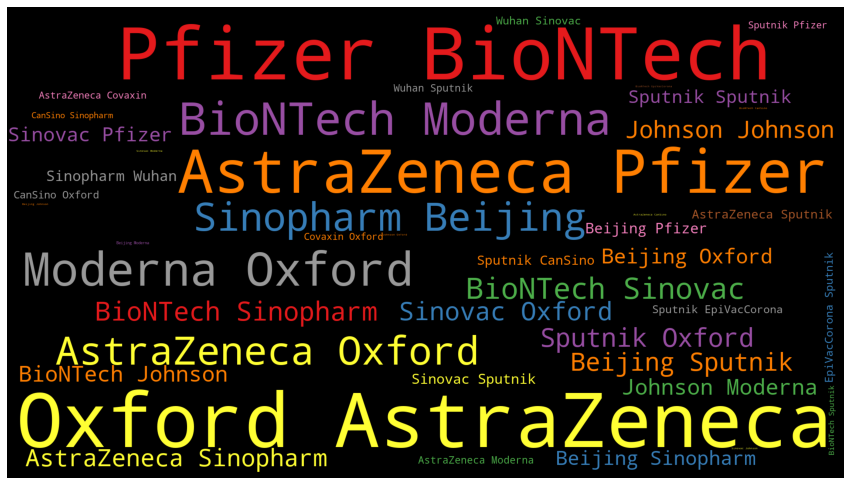

In [55]:
vaccinesDf = df["vaccines"]

wordcloud = WordCloud(background_color = "black", colormap="Set1", width = 1920, height = 1080).generate(" ".join(vaccinesDf))

plt.subplots(figsize=(15,15))
plt.axis("off")
plt.imshow(wordcloud)
plt.show()

A heatmap of the correlation between the columns in the dataset. As show in the heatmap, there is a strong correlation between a number of columns, such as the total_vaccinations with the people_vaccinated; also the total_vaccinations_per_hundred and the people_fully_vaccinated_per_hundred.

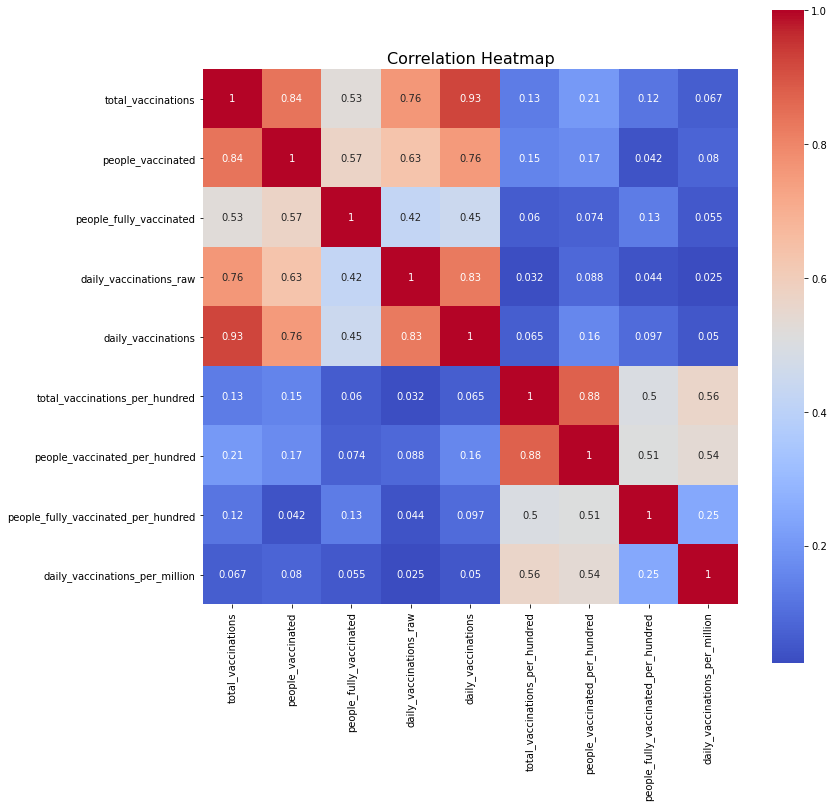

In [56]:
plt.subplots(figsize=(12, 12))
sns.heatmap(df.corr(), annot=True, square=True, cmap="coolwarm")
plt.title("Correlation Heatmap", size=16);   
plt.show()

Using an animated choropleth map to showcase how the total number of vaccinations has increased in various countries around the world as time has gone on. The totalVaccinationsDf is sorted by the date column and excludes the most recent day in which entries were made into the dataset as it doesn't contain complete values for all countries, resulting in the choropleth map not displaying correctly.

To visualise the progress of vaccinations around the world, drag the date bar to a specific date, alternatively click the play button to let the animation update automatically.

In [57]:
# https://plotly.com/python/choropleth-maps/

peopleVaccinatedDf = df[df["date"] < "2021-04-21"].sort_values(by="date")

fig = px.choropleth(data_frame=peopleVaccinatedDf, locations=peopleVaccinatedDf["country"], locationmode="country names", color=peopleVaccinatedDf["total_vaccinations"], animation_frame=peopleVaccinatedDf["date"], animation_group=peopleVaccinatedDf["vaccines"])
fig.update_layout({"title":"The Progress of Vaccinations Around the World"})
fig.show() 



---



---



**STAGE 2**: Determine property or question that may be suited to this project:



---



---



QUESTION: Can we predict the total vaccination numbers the United States will have in the next 90 days?

To do: Find a time series forecasting model that will be able to accurately predict the total vaccination numbers with given number of days/months



---



---



**STAGE 3**: Examine the data, from the perspective of the models, do you need to pre-process? Feature Extract? etc.



---



---



For the model, we only require the United States values in the dataset as that is the country which has the most interesting entries which we would like to work with further. The columns which we will need for this model are "date" and "total_vaccinations" and we must convert the date column from type object to datetime. 

After extensive research was carried out to find the best time series model, Prophet was chosen for this project. For Prophet to accept the columns in this dataset, they must be renamed to "ds" and "y" respectively. The "ds" column is the date, while the "y" column is the value which we are trying to predict (total_vaccinations in this case).

In [58]:
prophetDf = df[df["country"] == "United States"]
prophetDf["date"] = pd.to_datetime(prophetDf["date"])
prophetDf = prophetDf[["date", "total_vaccinations"]].rename(columns={"date": "ds", "total_vaccinations": "y"})

prophetDf.tail()

,ds,y
13231,2021-04-19,211581309.0
13232,2021-04-20,213388238.0
13233,2021-04-21,215951909.0
13234,2021-04-22,218947643.0
13235,2021-04-23,222322230.0


Lets also create a training dataframe and a testing dataframe using train_test_split. Notice that we are not getting x_train, y_train but instead both of these are stored inside trainDf, as Prophet accepts the entire dataframe to train the model.

The train_size was initially set to 0.7, but I noticed higher accuracy when upping it to 0.8. It seemed to be the perfect value to have the highest accuracy possible, while increasing or decreasing this number only resulted in worse results.

In [59]:
trainDf, testDf = train_test_split(prophetDf, train_size=0.8, random_state=2)



---



---



**STAGE 4**: Develop a model(s) and train it. Document choice of model with justification for all choices.

AND

**STAGE 5**: Evaluate and refine and repeat, again documenting as you go.



---



---



**Prophet model** - disable seasonalities as COVID-19 does not have this characteristic. It was an unforeseen event in the world, so we have to set these values to false. The confidence (interval_width) was set to 0.95, as this is what returned the best results in terms of model accuracy after extensive testing. By default, this value is set to 0.8.

We will use the trainDf created earlier to train the model. This training data is made up of 80% of the United States values from the original dataset. Fitting the model with 80% of values for training, as opposed to the alternative of 70% which was tested originally, returned better/more accurate results.

In [60]:
# https://facebook.github.io/prophet/docs/quick_start.html

model = Prophet(daily_seasonality=False, yearly_seasonality=False, interval_width=0.95)

model.fit(trainDf)

Lets start by creating a dataframe "futureDf" which consists of the 90 days (in datetime format). This is done using the Prophet model's useful function "make_future_dataframe".

In [61]:
futureDf = model.make_future_dataframe(periods=90)

futureDf.tail()

,ds
185,2021-07-18
186,2021-07-19
187,2021-07-20
188,2021-07-21
189,2021-07-22


After fitting the model with the training values received from train_test_split, we can now make a prediction by using the model's predict function and passing in the futureDf as a parameter (the dataframe which we created that contains the next 90 days in datetime format).

We are only interested in the columns "ds", "yhat", "yhat_lower", and "yhat_upper". The ds column symbolises the date, and the yhat column is the prediction made by the model. The yhat_lower and yhat_upper fields are those generated by the setting of the interval width (confidence interval) showing the possible lower and upper limits of the model's prediction.

In [62]:
forecastDf = model.predict(futureDf)

forecastDf = forecastDf[["ds", "yhat", "yhat_lower", "yhat_upper"]].round()

forecastDf.tail()

,ds,yhat,yhat_lower,yhat_upper
185,2021-07-18,493979475.0,425017355.0,557605220.0
186,2021-07-19,496537714.0,426934498.0,561277621.0
187,2021-07-20,499195999.0,427835205.0,565050112.0
188,2021-07-21,501983566.0,429314845.0,567886139.0
189,2021-07-22,505278006.0,431366089.0,573044855.0


Lets first do a simple line plot diagram to visualise how this model performed. We can plot the forecasted data along with the original test data taken from train_test_split on our original United States dataframe.

As shown in the diagram, the predicted line plot seems to follow a similar trend, and it appears that total vaccination number of up to 500M will be reached by the end of July 2021.

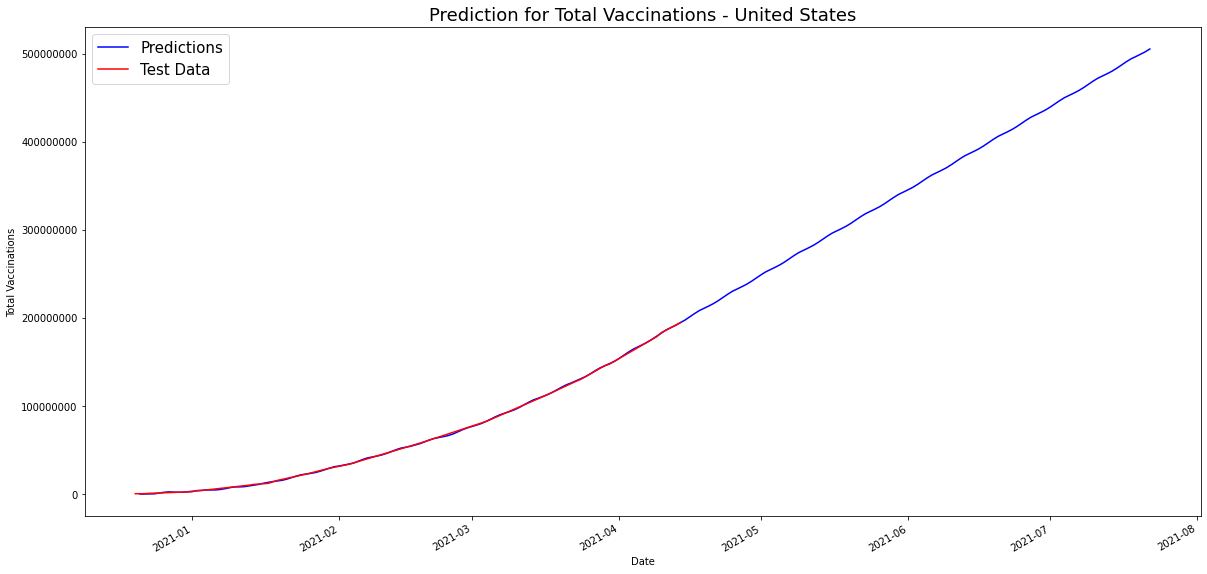

In [63]:
fig = forecastDf.plot(x="ds", y="yhat", legend=True, label="Predictions", figsize=(20,10), color="blue")
testDf.plot(x="ds", y="y", legend=True, label="Test Data", ax=fig, color="red")

plt.gcf().axes[0].yaxis.get_major_formatter().set_scientific(False)
plt.title("Prediction for Total Vaccinations - United States", size=18)
plt.legend(prop={"size": 15})
fig.set_xlabel("Date")
fig.set_ylabel("Total Vaccinations")
plt.show()

Now lets plot this line plot using plotly to get a more accurate representation of the predicted data. Using plotly, we can mouse over the line plot and see exact figures that the model has predicted. It can be seen that by July 22nd, the model predicts the total vaccination numbers in the United States will have reached 505M.

The red line in this graph symbolises the model being trained with the data retrieved from train_test_split (80% of the original United States data). Once the model has been successfully fitted, it stabilises and forms into the predicted curve which is shown on the plot below.

In [64]:
# https://community.plotly.com/t/how-to-plot-multiple-lines-on-the-same-y-axis-using-plotly-express/29219

fig = go.Figure()
fig.add_trace(go.Line(x=forecastDf["ds"], y=forecastDf["yhat"], mode="lines", name="Predictions"))
fig.add_trace(go.Line(x=testDf["ds"], y=testDf["y"], mode="lines", name="Test Data"))
fig.update_layout({"title":"Prediction for Total Vaccinations - United States"})
fig.update_xaxes({"title":"Date"})
fig.update_yaxes({"title":"Total Vaccinations"})
fig.show()

**Metrics** - The values used for gathering metrics were tested to find the best possible result and to discover how accurately this model actually performed. By looking at the prediction graph itself, it is clear that the model is quite accurate, so I am expecting the mean absolute percentage error to be quite low.

As discussed in Prophet's documentation and other resources online, the accuracy of the model can be calculated by subtracting the MAPE (mean absolute percentage error) from 100%. Lets see how to get the MAPE of our model.

Prophet includes functionality for time series cross validation to measure forecast error using historical data. This is done by selecting cutoff points in the history, and for each of them fitting the model using data only up to that cutoff point. We can then compare the forecasted values to the actual values.

The initial value is set to the size of the training data used for the model (100 days), while the period is set to the period of time which we are trying to predict (90 days). The forecast horizon value being set to 20 days seemed to return the most accurate results. Going above or below this figure seemed to increase the MAPE and reduce the accuracy of the model.

In [65]:
# https://facebook.github.io/prophet/docs/diagnostics.html
# https://github.com/facebook/prophet/issues/851

cv = cross_validation(model, initial="100 days", period="90 days", horizon="20 days")

INFO:fbprophet:Making 1 forecasts with cutoffs between 2021-04-03 00:00:00 and 2021-04-03 00:00:00


A lot of the values here are presented with scientific notation as the dataset we are dealing with stores numbers in the 100s of millions. The total number of vaccinations is expected to reach heights of 500 million in the next 90 days.

In [66]:
cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2021-04-04,1.621046e+08,1.608995e+08,1.631975e+08,165053746.0,2021-04-03
1,2021-04-05,1.642800e+08,1.630759e+08,1.655676e+08,167187795.0,2021-04-03
2,2021-04-06,1.667349e+08,1.655110e+08,1.681207e+08,168592075.0,2021-04-03
3,2021-04-07,1.691459e+08,1.678326e+08,1.704605e+08,171476655.0,2021-04-03
4,2021-04-08,1.718174e+08,1.704188e+08,1.733211e+08,174879716.0,2021-04-03


The metric which we are most interested in here is the MAPE (mean absolute percentage error) which tells us how accurate the model is.

The MAPE for this model is extremely low, which suggests that its accurately is high, and that the model itself is reliable for predicting future numbers, such as the total number of vaccinations.

In [67]:
performanceDf = performance_metrics(cv)
performanceDf[["horizon", "mape", "mdape"]]

,horizon,mape,mdape
0,1 days,0.017868,0.017868
1,2 days,0.017392,0.017392
2,3 days,0.011016,0.011016
3,4 days,0.013592,0.013592
4,5 days,0.017511,0.017511
5,8 days,0.034084,0.034084
6,9 days,0.036084,0.036084
7,10 days,0.036304,0.036304
8,12 days,0.039999,0.039999
9,13 days,0.043425,0.043425


At its peak, the MAPE only reaches a peak of about 0.048, which is excellent for this model. Once it reaches this level, it appears to stabilise at about 0.045, which is completely acceptable for making accurate time series predicitons.

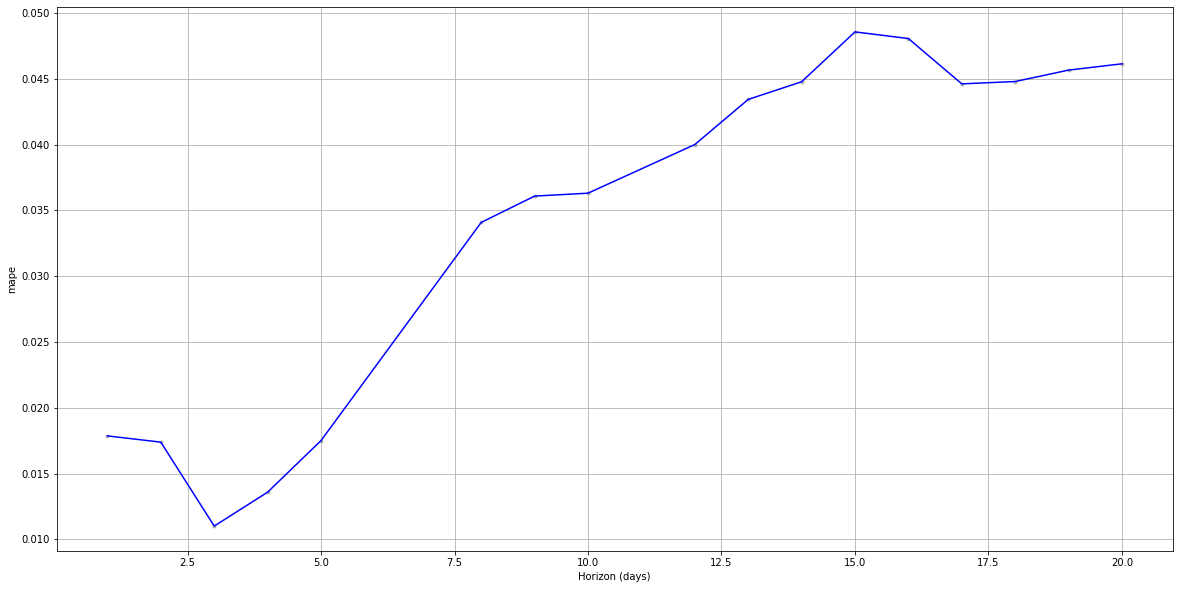

In [68]:
fig = plot_cross_validation_metric(cv, metric="mape", figsize=(20,10))

To check the % accuracy of the Prophet model, we can subtract the MAPE from 100. As shown below, the accuracy of this model is currently 99.9653%. This is the highest % that could be achieved with the modifications made to various parameters throughout setting up the model, such as training data, interval width, cross validation, and more.

In [69]:
print("The accuracy of the Prophet model is " + str(round(100 - performanceDf["mape"].mean(), 5)) + "%")

The accuracy of the Prophet model is 99.9653%


**Prophet** - 99.9653% Accuracy



---



---



**STAGE 6**: Present Results and Conclusions.



---



---



To conclude, it was clear that the Prophet time series model was an excellent choice for this dataset. It had an accuracy of 99.9653% at its peak allowing it to accurately predict future data.

The prediction made by the Prophet model revealed that the United States total vaccination numbers would exceed 500 million by the end of July 2021. This model could also be tweaked to be able to accurately predict figures for even further in the future.

This model could also be used to predict figures for other countries in this dataset, but there was a focus on the United States as that is the country which had the most interesting data in terms of the amount of entries and also it being the number 1 country for the amount of vaccinations (at the time of creating this project).



---



---



**Further Work**: Trying out the ARIMA time series model



---



---



There was also some testing around ARIMA (another time series forecasting model), although it seemed to be a lot more complex to configure than Prophet. The results returned from Prophet were already almost perfect, so the decision was made to continue using Prophet for other predictive analysis.

In [70]:
abcDf = df[df["country"] == "United States"]
abcDf["date"] = pd.to_datetime(abcDf["date"])
abcDf = abcDf[["date", "total_vaccinations"]]
abcDf.tail()

,date,total_vaccinations
13231,2021-04-19,211581309.0
13232,2021-04-20,213388238.0
13233,2021-04-21,215951909.0
13234,2021-04-22,218947643.0
13235,2021-04-23,222322230.0


Setting up ARIMA training and testing data with columns "date" and "total_vaccinations", again using the properties discussed earlier.

In [71]:
x = abcDf["date"]
y = abcDf["total_vaccinations"]

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, random_state=2)

In [72]:
!pip install pmdarima

In [73]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

model = pm.auto_arima(y_train, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=3902.846, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=3980.730, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=3938.479, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=3957.024, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=3903.797, Time=0.13 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=3902.768, Time=0.12 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=3957.317, Time=0.03 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.17 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=3900.714, Time=0.18 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=3952.231, Time=0.05 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=0.42 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=3897.830, Time=0.10 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=3896.823, Time=0.05 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=3894.921, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=3

**Top Left:** The standarised residual errors seem to fluctuate around a mean of zero and have a uniform variance between (2, -1).

**Top Right:** The density plot suggest normal distribution with a mean of zero.

**Bottom Left:** For the most part, the blue dots are over the red line, so it seems that the distribution is not skewed, still not as accurate as Prophet though.

**Bottom Right:** The Correlogram/ACF plot (autocorrelation function) shows the residual errors are not autocorrelated.

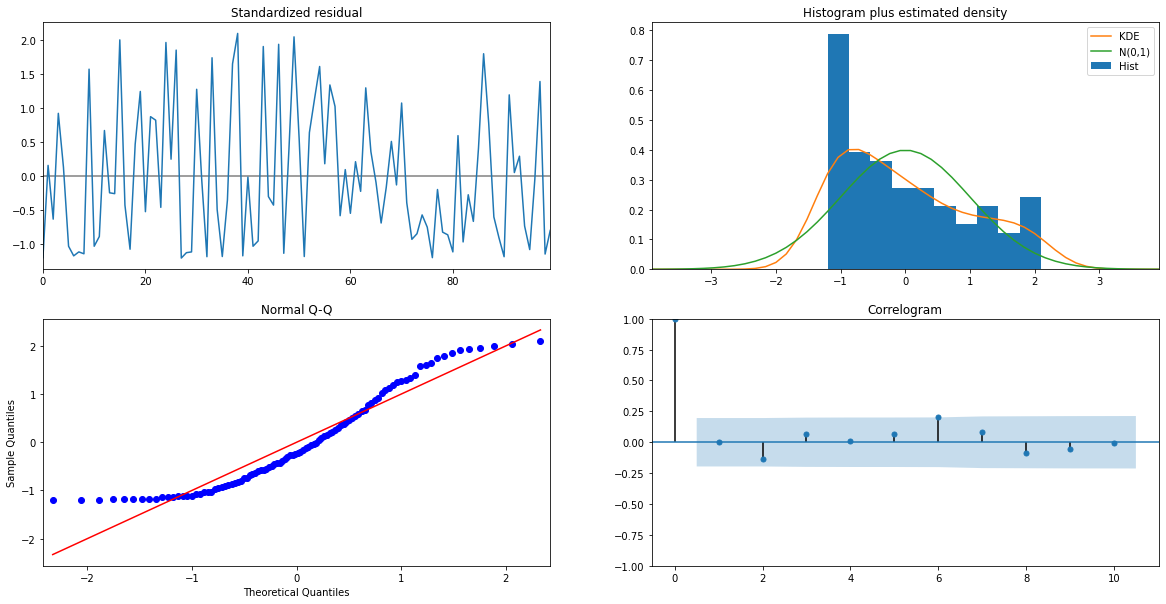

In [74]:
model.plot_diagnostics(figsize=(20, 10))
plt.show()